In [2]:
import pandas as pd
import re
import html
#nltk.download() #only for the first time running it
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import re
from datetime import datetime
import json
import regex as re
from textblob import TextBlob
import numpy as np
from wordcloud import WordCloud, STOPWORDS

In [36]:
import sys
print(sys.executable)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\python.exe


In [ ]:
test_data = pd.read_json('datain/nft_search_tweets_sample.jsonl')
test_data

In [ ]:
#create dataframe on media posts USE FOR ALL DATA - Don't run now
def createDataFrame():  
    with open("datain/nft_search_tweets_sample.jsonl", encoding='utf8') as f:
        for line in f:
            row = json.loads(line)
            try:
                if row["lang"] == 'en' and len(row.get('referenced_tweets', [])) == 0 and len(row.get('entities', ['hashtags'])) != 0:
                    yield (row['id'],
                            row['text'],
                            row['entities']['hashtags'],
                            row['public_metrics']['retweet_count'],
                            row['public_metrics']['quote_count'],
                            row['public_metrics']['reply_count'],
                            row['public_metrics']['like_count'],
                            row['attachments']['media_keys'])
            except KeyError:
                pass

#create csv
df = pd.DataFrame(createDataFrame())
df.columns =['id', 'text', 'hashtags', 'retweet_count', 'quote_count', 'reply_count', 'like_count', 'media_keys']
df.to_json('datain/nft_tweets.jsonl', orient='records', index=True, lines= True)
output = pd.read_json("datain/nft_tweets.jsonl", lines = True)
output['total'] = output[['retweet_count', 'quote_count','reply_count', 'like_count']].sum(axis=1)
#sort by highest total
output = output.sort_values(by = 'total', ascending = False)
#top 100
output = output.head(100)
output.to_json('datain/nft_top_100_tweets.jsonl', orient='records', index=True, lines= True)

In [ ]:
#import the data
data = pd.read_json("datain/nft_top_100_tweets.jsonl", lines=True)

In [ ]:
#prep stop words
stop_words = stopwords.words('english')
stop_words.append('rt')
stop_words.append('nft')
# stop_words.append('#nft')

#function for cleaning a tweet (remove mentions, hashtags, links, html entities, stop words. And make sure it's only letters)
def clean_tweet(tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        tweet = str.lower(tweet)
        # tweet = ' '.join(re.sub("(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
        tweet = ' '.join(re.sub("(@[A-Za-z0-9_]+)|(#[A-Za-z0-9_]+)", " ", tweet).split()) # remove mentions and hashtags
        # tweet = ' '.join(re.sub("(@[A-Za-z0-9_]+)", " ", tweet).split())
        tweet = re.sub("(http\S+|http)", "", tweet, flags=re.MULTILINE) # remove links
        tweet = re.sub('\&\w+', "", tweet) # remove html entities
        tweet = re.sub('[^a-zA-Z# ]+', ' ', tweet) # make sure tweet is only letters
        # stem & remove stop words
        # tweet = ' '.join([PorterStemmer().stem(word=word) for word in tweet.split() if word not in stop_words])
        tweet = ' '.join([word for word in tweet.split() if word not in stop_words])
        return tweet

#clean data
for i in data.index:
    text = data["text"][i]
    cleaned_text = clean_tweet(text)
    cleaned_text = html.unescape(cleaned_text)
    data["text"][i] = cleaned_text

In [ ]:
data.to_json('datain/nft_top_100_cleaned_interactions.jsonl', orient='records', index=True, lines= True)

In [ ]:
#nft_top_100_sentiment <- Has interactions and sentiment totals
positivity = ''
def getSentiment():
    output = pd.read_json("datain/nft_top_100_cleaned_interactions.jsonl", lines = True)
    output = pd.DataFrame(output)
    for i in output.index:
        row = TextBlob(output.iloc[i]['text'])
        if row.sentiment.polarity >= 0.7:
                positivity = 'mostly_positive'
        elif row.sentiment.polarity <= -0.7:
            positivity = 'mostly_negative'
        elif row.sentiment.polarity > -0.7 and row.sentiment.polarity < -0.4:
            positivity = 'negative'
        elif row.sentiment.polarity > 0.4 and row.sentiment.polarity < 0.7:
                positivity = 'positive'
        else:
            positivity = 'nuetral'
        yield  row.sentiment.polarity, row.sentiment.subjectivity, positivity
    # with open("datain/cleaned.txt", encoding='utf8') as f:
    #     for line in f:
    #         row = TextBlob(line)
    #         if row.sentiment.polarity >= 0.7:
    #             positivity = 'mostly_positive'
    #         elif row.sentiment.polarity <= -0.7:
    #             positivity = 'mostly_negative'
    #         elif row.sentiment.polarity > -0.7 and row.sentiment.polarity < -0.4:
    #             positivity = 'negative'
    #         elif row.sentiment.polarity > 0.4 and row.sentiment.polarity < 0.7:
    #              positivity = 'positive'
    #         else:
    #             positivity = 'nuetral'
    #         yield line, row.sentiment.polarity, row.sentiment.subjectivity, positivity

df = pd.DataFrame(getSentiment())
df.columns =['polarity', 'subjectivity', 'positivity']
output['polarity'] = df['polarity']
output['subjectivity'] = df['subjectivity']
output['positivity'] = df['positivity']
output.to_json('datain/nft_top_100_cleaned_interactions_sentiment.jsonl', orient='records', index=True, lines= True)

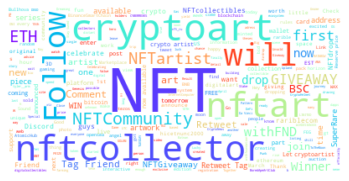

In [10]:
# Word cloud of top 100 NFT's
top_100_word_cloud = pd.read_json("datain/nft_top_100_cleaned_interactions_sentiment.jsonl", lines=True)
# Generate a word cloud image
stopwords = set(STOPWORDS)
stopwords.update(("t", "co", "https", "t", "amp", "RT"))
wordcloud = WordCloud(stopwords=stopwords,background_color='white', max_words=1000,contour_color='#023075',contour_width=3,colormap='rainbow').generate(' '.join(top_100_word_cloud['text']))
# create image as cloud
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# store to file
plt.savefig("cloud.png", format="png")
plt.show()

In [10]:
# Comment sentiment
#### Read from nft_search_tweets_sample - need replied to with text and author
#### Original Poster
def createOriginalDataFrame():  
    with open("datain/nft_search_tweets_sample.jsonl", encoding='utf8') as f:
        for line in f:
            row = json.loads(line)
            try:
                if row["lang"] == 'en'and len(row.get('referenced_tweets', [])) == 0:
                    yield (row['id'],
                            row['text'],
                            row['author_id'],
                    )
            except KeyError:
                pass

def createRepliesDataFrame():  
    with open("datain/nft_search_tweets_sample.jsonl", encoding='utf8') as f:
        for line in f:
            row = json.loads(line)
            try:
                if row["lang"] == 'en'and len(row.get('referenced_tweets', [])) != 0:
                    yield (row['id'],
                            row['text'],
                            row['author_id'],
                            row['in_reply_to_user_id'],
                    )
            except KeyError:
                pass
#create csv
original_data = pd.DataFrame(createOriginalDataFrame())
original_data.columns =['id', 'text', 'original_author_id']
original_data.to_json('datain/nft_original_tweets.jsonl', orient='records', index=True, lines= True)

replies_data = pd.DataFrame(createRepliesDataFrame())
replies_data.columns =['id', 'text', 'reply_author_id', 'in_reply_to_user_id']
replies_data.to_json('datain/nft_replies_tweets.jsonl', orient='records', index=True, lines= True)

In [27]:
replies_data['matched_id'] = pd.Series((original_data.original_author_id.isin(replies_data.reply_author_id)))

In [28]:
data=[]
for i in replies_data.index:
    if(replies_data.iloc[i]['matched_id'] == True):
        data.append(replies_data.iloc[i])
matched_df = pd.DataFrame(data)